# Usage of the CheXmask Database

The annotations are released as tables, in .csv.gz compressed format. Each table contains the following columns:

**Column** | **Description** 
--- | --- 
Image ID | Contains references to the original images as per the original metadata, thus the column name changes across dataset. 
Dice RCA (Max) | Provides the maximum Dice Similarity Coefficient for the Reverse Classification Accuracy (RCA), indicating the quality of the segmentation. 
Dice RCA (Mean) | Provides the mean Dice Similarity Coefficient for the Reverse Classification Accuracy (RCA), indicating the quality of the segmentation. 
Landmarks | Includes a set of points representing the contour of the organs, as obtained by the HybridGNet. 
Left Lung | Contains segmentation masks of the left lung in run-length encoding (RLE). 
Right Lung | Contains segmentation masks of the right lung in RLE. 
Heart | Contains segmentation masks of the heart in RLE. 
Height | Height of the segmentation mask, necessary to decode RLE. 
Width | Width of the segmentation mask, necessary to decode RLE. 



In [26]:
import pandas as pd
from DataPostprocessing.utils import get_mask_from_RLE
import numpy as np 
import matplotlib.pyplot as plt 

path = "../Annotations/OriginalResolution/VinDr-CXR.csv.gz"
df = pd.read_csv(path)

columns = df.columns

print("Dataset: VinDr-CXR")
print("Shape", df.shape)
print(columns)

Dataset: VinDr-CXR
Shape (18000, 9)
Index(['image_id', 'Dice RCA (Mean)', 'Dice RCA (Max)', 'Landmarks',
       'Left Lung', 'Right Lung', 'Heart', 'Height', 'Width'],
      dtype='object')


Landmarks with one-to-one correspondences can be obtained from the .csv file

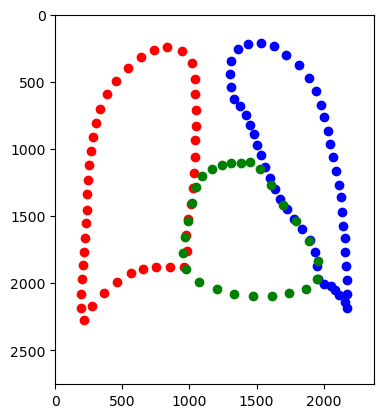

In [27]:
example = df.iloc[0]

landmarks = example["Landmarks"]
height, width = example["Height"], example["Width"]

# As landmarks are stored as a string, we need to convert it to a numpy array
try:
    landmarks = eval(landmarks)
except:
    # Depending on python versions, the above code may not work, but this one should
    landmarks = landmarks.replace('[ ', '[').replace('\n ', ',').replace('  ', ',').replace(' ', ',')
    landmarks = eval(landmarks)
    
landmarks = np.array(landmarks).reshape(-1, 2)

rightLungLandmarks = landmarks[:44, :]
leftLungLandmarks = landmarks[44:94, :]
heartLandmarks = landmarks[94:, :]

plt.figure()

plt.scatter(rightLungLandmarks[:, 0], rightLungLandmarks[:, 1], c = "r")
plt.scatter(leftLungLandmarks[:, 0], leftLungLandmarks[:, 1], c = "b")
plt.scatter(heartLandmarks[:, 0], heartLandmarks[:, 1], c = "g")

plt.xlim(0, width)
plt.ylim(0, height)

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

Using provided functions such as "get_mask_from_RLE", binary segmentations masks can be obtained for each individual organ

Text(0.5, 1.0, 'Heart Mask')

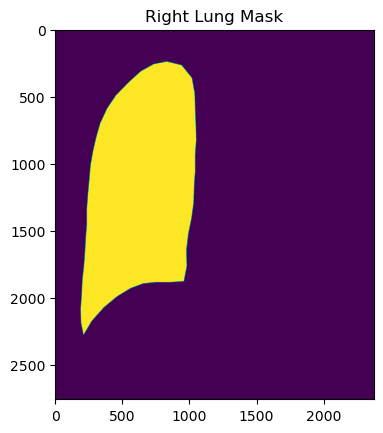

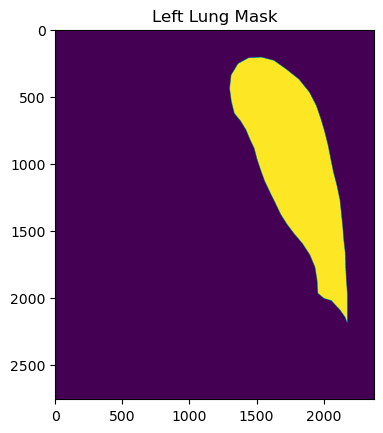

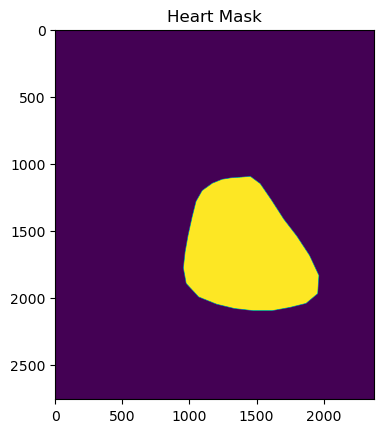

In [28]:
rightLungMask_RLE = example["Right Lung"]
leftLungMask_RLE = example["Left Lung"]
heartMask_RLE = example["Heart"]

rightLungMask = get_mask_from_RLE(rightLungMask_RLE, height, width)
leftLungMask = get_mask_from_RLE(leftLungMask_RLE, height, width)
heartMask = get_mask_from_RLE(heartMask_RLE, height, width)

plt.figure()
plt.imshow(rightLungMask)
plt.title("Right Lung Mask")

plt.figure()
plt.imshow(leftLungMask)
plt.title("Left Lung Mask")

plt.figure()
plt.imshow(heartMask)
plt.title("Heart Mask")

Code below can help to provide a visual representation of all segmentation masks

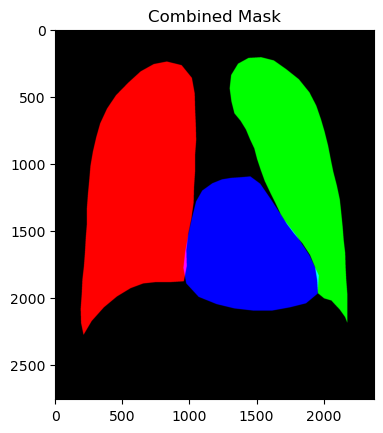

In [29]:
# Combine masks, in different colors

mask = np.zeros([height, width, 3], dtype = np.uint8)
mask[:, :, 0] = rightLungMask
mask[:, :, 1] = leftLungMask
mask[:, :, 2] = heartMask

plt.figure()
plt.imshow(mask)
plt.title("Combined Mask")
plt.show()

With the contour landmarks on top of it

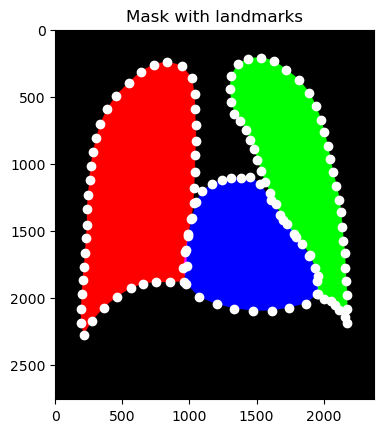

In [30]:
# Combine masks with landmarks

plt.figure()

plt.imshow(mask)
plt.scatter(rightLungLandmarks[:, 0], rightLungLandmarks[:, 1], c = "w")
plt.scatter(leftLungLandmarks[:, 0], leftLungLandmarks[:, 1], c = "w")
plt.scatter(heartLandmarks[:, 0], heartLandmarks[:, 1], c = "w")

plt.title("Mask with landmarks")

plt.show()

Finally, as an example, we use a sample image obtained from Wikipedia, released under CC0 Universial Public Domain. Source: https://commons.wikimedia.org/wiki/File:Normal_posteroanterior_(PA)_chest_radiograph_(X-ray).jpg

Segmentation was performed using the HybridGNet model, available online in: https://huggingface.co/spaces/ngaggion/Chest-x-ray-HybridGNet-Segmentation

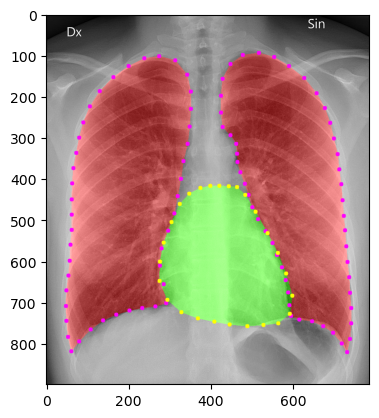

In [35]:
import cv2

def drawOnTop(img, landmarks, original_shape):
    h, w = original_shape
    output = getDenseMask(landmarks, h, w)
    
    image = np.zeros([h, w, 3])
    image[:,:,0] = img + 0.3 * (output == 1).astype('float') - 0.1 * (output == 2).astype('float')
    image[:,:,1] = img + 0.3 * (output == 2).astype('float') - 0.1 * (output == 1).astype('float') 
    image[:,:,2] = img - 0.1 * (output == 1).astype('float') - 0.2 * (output == 2).astype('float') 

    image = np.clip(image, 0, 1)
    
    RL, LL, H = landmarks[0:44], landmarks[44:94], landmarks[94:]
    
    # Draw the landmarks as dots
    
    for l in RL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in LL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in H:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 1, 0), -1)
    
    return image

def getDenseMask(landmarks, h, w):
    
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    img = np.zeros([h, w], dtype = 'uint8')
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 1, -1)
    img = cv2.drawContours(img, [H], -1, 2, -1)
    
    return img

img = cv2.imread("Example/utils_example1.jpg", cv2.IMREAD_GRAYSCALE) / 255.0
original_shape = img.shape
RL = np.loadtxt("Example/RL_landmarks.txt")
LL = np.loadtxt("Example/LL_landmarks.txt")
H = np.loadtxt("Example/H_landmarks.txt")
landmarks = np.concatenate([RL, LL, H], axis = 0)

output = drawOnTop(img, landmarks, original_shape)
plt.imshow(output)